# Model Training

Original shape: (2300, 9), after PCA: (2300, 4)

Training and tuning Logistic Regression...
Best params for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
F1-score (macro) on test set for Logistic Regression: 0.9144


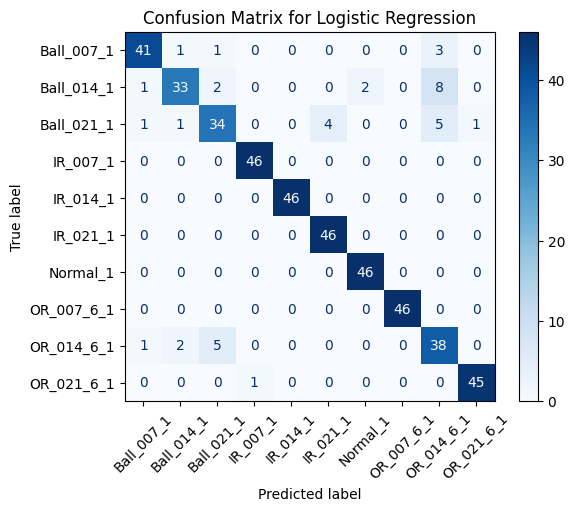


Training and tuning KNN...
Best params for KNN: {'n_neighbors': 5, 'weights': 'distance'}
F1-score (macro) on test set for KNN: 0.9081


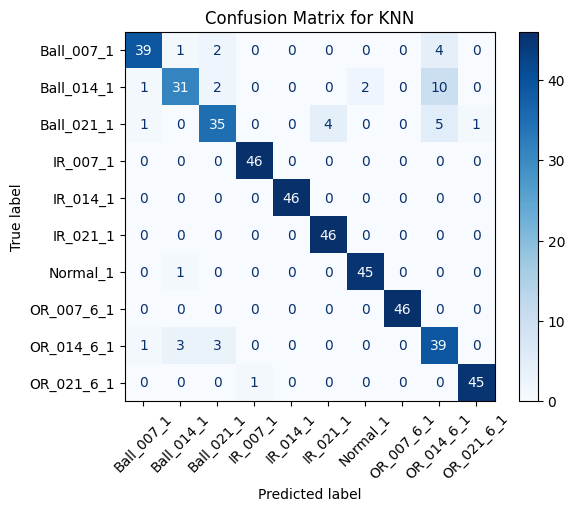


Training and tuning SVC...
Best params for SVC: {'C': 10, 'kernel': 'linear'}
F1-score (macro) on test set for SVC: 0.9364


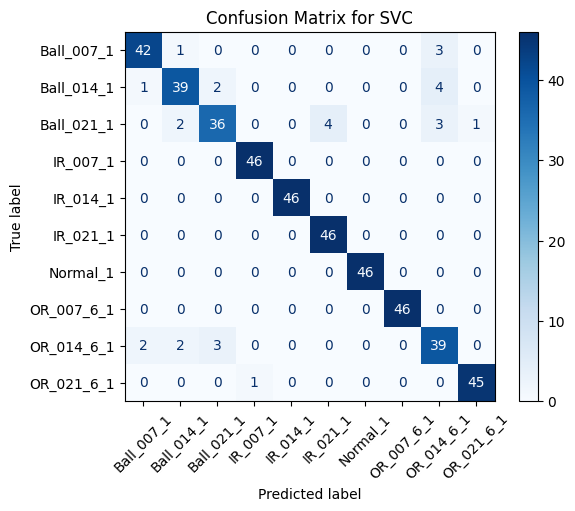


Training and tuning XGBoost...


c:\Users\DELL\Desktop\PC\Bearing_Fault_Diagnosis\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
F1-score (macro) on test set for XGBoost: 0.9114


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('data/raw.csv')
X = df.drop('fault', axis=1)
y = df['fault']

# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction (choose n_components to keep ~95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f'Original shape: {X_scaled.shape}, after PCA: {X_pca.shape}')

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Hyperparameter grids for GridSearchCV
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "SVC": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
}

# To store results
best_estimators = {}
f1_scores = {}

for name, model in models.items():
    print(f"\nTraining and tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], scoring='f1_macro', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    
    # Evaluate on test data
    y_pred = grid.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores[name] = f1
    print(f"F1-score (macro) on test set for {name}: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Feature importances for XGBoost
xgb = best_estimators['XGBoost']
# We have PCA transformed features, so feature importance corresponds to components
# Just plot feature importances from XGBoost's original features (before PCA)
xgb.fit(X_train, y_train)
plt.figure(figsize=(10,6))
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.xlabel('Features (PCA components)')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importances (PCA components)')
plt.show()

# Summary of F1 scores
print("\nSummary of F1 scores:")
for model_name, score in f1_scores.items():
    print(f"{model_name}: {score:.4f}")
